In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from astropy.io import fits
pandarallel.initialize(progress_bar=True)
import random
from numpy.random import default_rng
import numpy as np
rng = default_rng(42)
import shutil
import glob
from scipy import ndimage



Bad key text.latex.preview in file /opt/anaconda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
path = '/data/processing/avera/proyecto_deep/'
df = pd.read_csv("zvar2.csv")

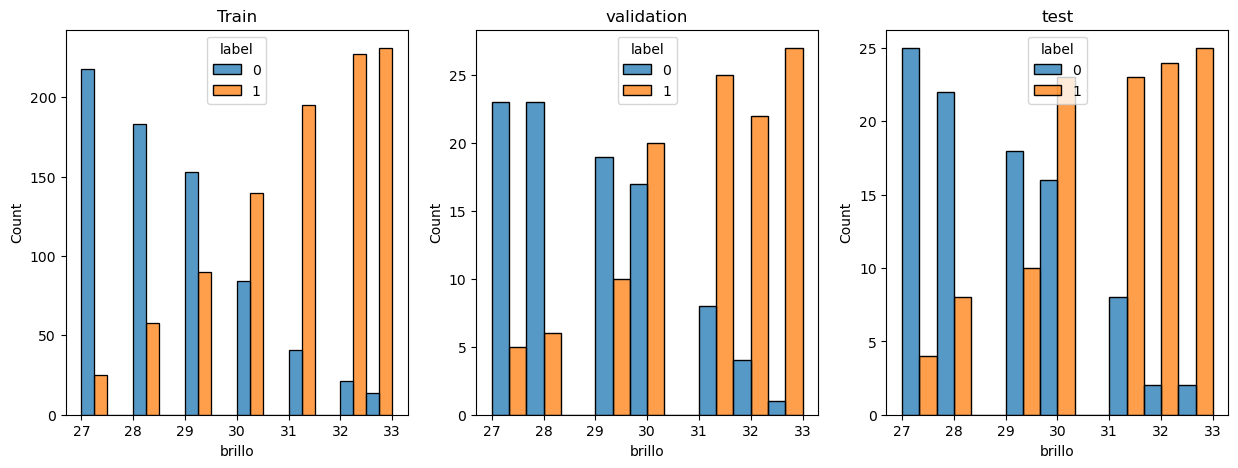

In [3]:
df_final = pd.DataFrame({})
for i in range(27,34):
    i = str(i)
    df_variable = df[["AU"]] +"_SB"+i
    df_variable["label"] = df[i]
    df_final = pd.concat([df_final,df_variable])

df_final = df_final.reset_index(drop=True)
df_final["brillo"] = df_final["AU"].str.split("_SB").str[-1]
df_final["brillo"] = df_final["brillo"].astype(float)

df_final.loc[df_final.sample(frac=0.1,weights='brillo',random_state=2).index,"subgrup"] = "test"
mask1 = df_final.loc[df_final["subgrup"]!="test"].sample(frac=0.111,weights='brillo',random_state=2).index
df_final.loc[mask1,"subgrup"] = "val"
df_final.loc[df_final["subgrup"].isna(),"subgrup"] = "train"

fig,ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=ax[0],data=df_final.loc[df_final["subgrup"]=="train"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[1],data=df_final.loc[df_final["subgrup"]=="val"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[2],data=df_final.loc[df_final["subgrup"]=="test"],x="brillo",hue="label", multiple="dodge")
ax[0].set_title('Train')
ax[1].set_title('validation')
ax[2].set_title('test')
fig.show()



In [4]:
def abrir_fits(ruta):
    hdu_list = fits.open(ruta,memmap=False)
    image_data = hdu_list[0].data
    hdu_list.close()
    return image_data

In [5]:
def data_augmentation(path_plots,nomb,img,rng,tipo,numero):
    '''
    Función que genera una imagen fits con rotación al azar entre 0 y 360
    El rng permite que no se repitan las rotaciones
    hay un choice para seleccionar flip en el eje x, y o ambos
    '''

    angulo_de_rotacion = rng.choice(360, size=1, replace=False)[0]
    img_rotate = ndimage.rotate(img,angulo_de_rotacion, reshape=False,mode='reflect',order=1)
    flip_x = np.fliplr(img_rotate)
    flip_y = np.flipud(img_rotate)
    flip_xy = np.flipud(np.fliplr(img_rotate))
    mylist = [flip_x,flip_y,flip_xy]
    random_image = random.choice(mylist)
    plt.imshow(random_image, cmap=plt.cm.brg)
    hdu = fits.PrimaryHDU(random_image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(f'{path_plots}{tipo}/{numero}_{nomb}.fits',overwrite=True)
    return

train = df_final.loc[df_final["subgrup"]=="train"].reset_index(drop=True)
val = df_final.loc[df_final["subgrup"]=="val"].reset_index(drop=True)
test = df_final.loc[df_final["subgrup"]=="test"].reset_index(drop=True)

train.to_csv("/data/processing/avera/proyecto_deep/zvar_dat_aug/train.csv",index=False)
val.to_csv("/data/processing/avera/proyecto_deep/zvar_dat_aug/val.csv",index=False)
test.to_csv("/data/processing/avera/proyecto_deep/zvar_dat_aug/test.csv",index=False)


In [6]:
train["image"] = train.parallel_apply(lambda row : abrir_fits(f"{path}/fits_zvar2/"+ row["AU"]+".fits"), axis=1)

In [7]:
numero_training = train.groupby(["brillo","label"]).count()["AU"].max()
numero_training

231

In [8]:
training_df = train.loc[train["label"]==1].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])

for tipos in training_df["brillo"].unique() :
    print(tipos)
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/zvar_dat_aug/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path}/zvar_dat_aug/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/zvar_dat_aug/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")
    

27.0


28.0


29.0


30.0


31.0


32.0


33.0


In [9]:
training_df = train.loc[train["label"]==0].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])

for tipos in training_df["brillo"].unique() :
    print(tipos)
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/zvar_dat_aug/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path}/zvar_dat_aug/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/zvar_dat_aug/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")
    

27.0


28.0


29.0


30.0


31.0


32.0


33.0


In [10]:

train.loc[train["label"]==0].apply(lambda row : shutil.copy(f"{path}/fits_zvar2/" + row["AU"] +".fits",f"{path}zvar_dat_aug"),axis=1,result_type="expand")


0       /data/processing/avera/proyecto_deep/zvar_dat_...
1       /data/processing/avera/proyecto_deep/zvar_dat_...
2       /data/processing/avera/proyecto_deep/zvar_dat_...
3       /data/processing/avera/proyecto_deep/zvar_dat_...
4       /data/processing/avera/proyecto_deep/zvar_dat_...
                              ...                        
1564    /data/processing/avera/proyecto_deep/zvar_dat_...
1565    /data/processing/avera/proyecto_deep/zvar_dat_...
1568    /data/processing/avera/proyecto_deep/zvar_dat_...
1569    /data/processing/avera/proyecto_deep/zvar_dat_...
1578    /data/processing/avera/proyecto_deep/zvar_dat_...
Length: 714, dtype: object

In [11]:

train.loc[train["label"]==1].parallel_apply(lambda row : shutil.copy(f"{path}/fits_zvar2/" + row["AU"] +".fits",f"{path}/zvar_dat_aug/"),axis=1,result_type="expand")


24      /data/processing/avera/proyecto_deep//zvar_dat...
25      /data/processing/avera/proyecto_deep//zvar_dat...
26      /data/processing/avera/proyecto_deep//zvar_dat...
27      /data/processing/avera/proyecto_deep//zvar_dat...
28      /data/processing/avera/proyecto_deep//zvar_dat...
                              ...                        
1675    /data/processing/avera/proyecto_deep//zvar_dat...
1676    /data/processing/avera/proyecto_deep//zvar_dat...
1677    /data/processing/avera/proyecto_deep//zvar_dat...
1678    /data/processing/avera/proyecto_deep//zvar_dat...
1679    /data/processing/avera/proyecto_deep//zvar_dat...
Length: 966, dtype: object

<Axes: xlabel='SB', ylabel='Count'>

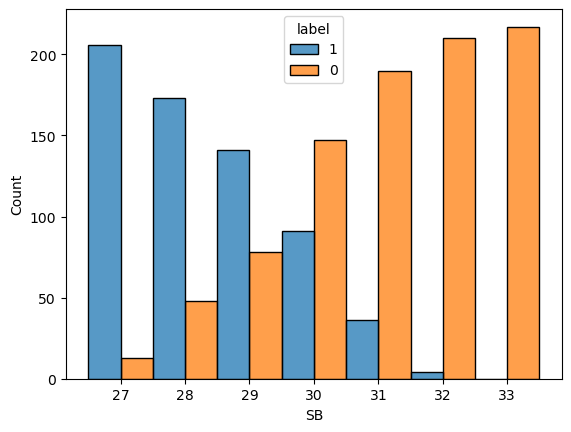

In [12]:
train = pd.concat([pd.DataFrame(glob.glob(f"{path}zvar_dat_aug/1/*"),columns=["direccion"]),pd.DataFrame(glob.glob(f"{path}zvar_dat_aug/0/*"),columns=["direccion"])]).reset_index(drop=True)

train["SB"] = train['direccion'].str.split("/").str[7].str.split("_").str[-1].str[2:4]

train["label"] = train["direccion"].str.split("/").str[-2]

sns.histplot(data=train,x="SB",hue="label", multiple="dodge")



<Axes: xlabel='SB', ylabel='Count'>

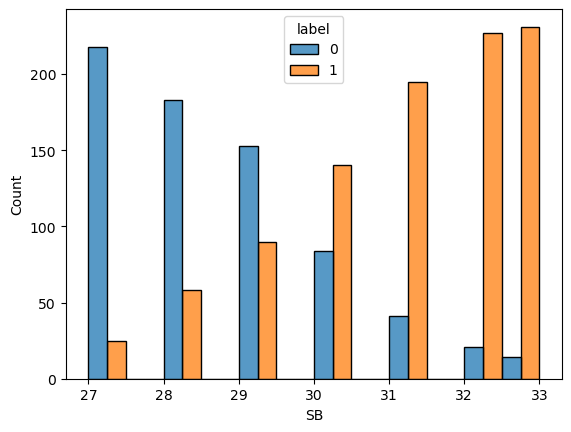

In [13]:
train2 = pd.read_csv(f"{path}zvar_dat_aug/train.csv")
train2["SB"] = train2['brillo']
train2["label"] = train2["label"]
sns.histplot(data=train2,x="SB",hue="label", multiple="dodge")

In [14]:
#ttt = pd.DataFrame({'direccion':pd.concat([train['direccion'].str.split("/").str[7].str[:-5],train2['AU']]).reset_index(drop=True)}).reset_index(drop=True)
ttt = pd.DataFrame({'direccion':pd.concat([train['direccion'],"/data/processing/avera/proyecto_deep/fits_zvar2/" + train2['AU'] + ".fits"]).reset_index(drop=True)}).reset_index(drop=True)
ttt['SB'] = pd.concat([train["SB"].apply(int),train2["SB"].apply(int)]).reset_index(drop=True)
ttt['label'] = pd.concat([train["label"].apply(int),train2["label"].apply(int)]).reset_index(drop=True)

<Axes: xlabel='SB', ylabel='Count'>

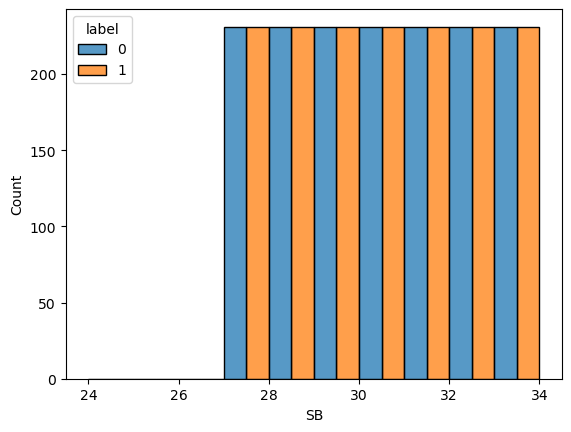

In [15]:
sns.histplot(data=ttt,x="SB",hue="label", multiple="dodge",bins=np.arange(24,35,1))

In [16]:
val = pd.read_csv(f"/{path}zvar_dat_aug/val.csv")
test = pd.read_csv(f"/{path}zvar_dat_aug/test.csv")
val["direccion"] = path +  "fits_zvar2/" +  val["AU"]+".fits"
test["direccion"] = path+  "fits_zvar2/" + test["AU"]+".fits"
test["image"] = test.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)
val["image"] = val.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)

In [17]:
ttt["image"] = ttt.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)

In [18]:
ttt["label"] = ttt.label.astype("int")
val["label"] = val.label.astype("int")
test["label"] = test.label.astype("int")

In [19]:
x_train = np.empty((len(ttt),300, 300,3))
x_val = np.empty((len(val),300,300,3))
x_test = np.empty((len(test),300,300,3))

for i,ima in enumerate(ttt["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_train[i] = img2

for i,ima in enumerate(val["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_val[i] = img2
    
for i,ima in enumerate(test["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_test[i] = img2

In [20]:
np.max(x_train),np.min(x_train),ttt.SB.unique()

(1.0, 0.0, array([27, 28, 29, 30, 31, 32, 33]))

In [22]:
import h5py
with h5py.File("/data/processing/avera/proyecto_deep/zvar_dat_aug/zvar2.h5", 'w') as hdf:
    # Guardar set de entrenamiento
    hdf.create_dataset('x_train', data=x_train)
    hdf.create_dataset('train_labels', data=ttt.label)
    hdf.create_dataset('train_sb', data=ttt.SB)
    # Guardar set de validación
    hdf.create_dataset('x_val', data=x_val)
    hdf.create_dataset('val_labels', data=val.label)
    hdf.create_dataset('val_sb', data=val.brillo)
    # Guardar set de testeo
    hdf.create_dataset('x_test', data=x_test)
    hdf.create_dataset('test_labels', data=test.label)
    hdf.create_dataset('test_sb', data=test.brillo)

